# Part 2 - GRU

## Imports

In [1]:
import torch 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import os
import json
import gensim
import re
import torch.optim as optim
from torchtext.vocab import GloVe, FastText
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, f1_score
from gensim.models import KeyedVectors
from tqdm.notebook import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load processed data

In [2]:
with open('../data_processed/LR_train_tagged.json') as f: 
    LR_train = json.load(f)
    
with open('../data_processed/LR_test_tagged.json') as f:
    LR_test = json.load(f)
    
with open('../data_processed/LR_val_tagged.json') as f:
    LR_val = json.load(f)

with open('../data_processed/NER_train_tagged.json') as f:
    NER_train = json.load(f)

with open('../data_processed/NER_test_tagged.json') as f:
    NER_test = json.load(f)

with open('../data_processed/NER_val_tagged.json') as f:
    NER_val = json.load(f)


## Load vector embedding models

### Word2Vec


In [3]:
w2vmodel = KeyedVectors.load_word2vec_format('../.vector_cache/GoogleNews-vectors-negative300.bin', binary=True)

### GloVe


In [4]:
# glovemodel = GloVe(name='6B', dim=300)
glove_file = '../.vector_cache/glove.6B.300d.txt'
glovemodel = {}
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        glovemodel[word] = vector


### Fasttext

In [5]:
# fasttextmodel = FastText()
fasttext_file = '../.vector_cache/wiki.en.vec'
fastmodel = {}
with open(fasttext_file, 'r', encoding='utf-8') as f:
    next(f)
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        vector = np.array([x for x in values[1:] if x], dtype='float32')
        fastmodel[word] = vector

## Creating and Training the Models

### Create list of unique labels - NER

In [6]:
unique_labels = []
for entry in NER_train:
    labels = entry['labels']
    for label in labels:
        unique_labels.append(label)

label_dict_NER = {}
unique_labels = list(set(unique_labels))

for label_index in range(len(unique_labels)):
    label_dict_NER[unique_labels[label_index]] = label_index

# label_dict_NER['p0p'] = len(unique_labels)
# label_dict['UNK'] = len(unique_labels) + 1

output_dict = {}
for key, value in label_dict_NER.items():
    new_key = key.replace('B_', '').replace('I_', '')
    if new_key not in output_dict:
        output_dict[new_key] = len(output_dict)

label_dict_NER = output_dict
label_dict_NER

{'CASE_NUMBER': 0,
 'STATUTE': 1,
 'DATE': 2,
 'O': 3,
 'PROVISION': 4,
 'ORG': 5,
 'WITNESS': 6,
 'OTHER_PERSON': 7,
 'JUDGE': 8,
 'PETITIONER': 9,
 'RESPONDENT': 10,
 'COURT': 11,
 'GPE': 12,
 'PRECEDENT': 13}

### Create list of unique labels - LR

In [7]:
unique_labels = []
for entry in LR_train:
    labels = entry['labels']
    for label in labels:
        unique_labels.append(label)

label_dict_LR = {}
unique_labels = list(set(unique_labels))

for label_index in range(len(unique_labels)):
    label_dict_LR[unique_labels[label_index]] = label_index

# label_dict_LR['p0p'] = len(unique_labels)
# label_dict['UNK'] = len(unique_labels) + 1
label_dict_LR

{'O': 0, 'B': 1, 'I': 2}

### Verifying LR_train

In [8]:
# id = 0
# for entry in LR_train:
#     if (len(entry['text'].split()) != len(entry['labels'])):
#         print(entry['id'])
#         print(len(entry['text'].split()))
#         print(len(entry['labels']))

### Define NER dataset class

In [9]:
class NER_dataset(Dataset):
    def __init__(self, dataset, embedding="word2vec", padding=True):
        self.padding_word = "O"
        # self.padding_word = "p0p"

        if embedding == "word2vec":
            self.model = w2vmodel
            self.model.add_vector(self.padding_word, np.zeros(300))
        elif embedding == "glove":
            self.model = glovemodel
            self.model[self.padding_word] = np.zeros(300)
        else:
            self.model = fastmodel
            self.model[self.padding_word] = np.zeros(300)
            
        self.data = dataset
        self.input = []
        self.labels = []
        
        for i in range(len(self.data)):
            lst = self.data[i]["labels"]
            for j in range(len(lst)):
                if lst[j].startswith("B_"):
                    lst[j] = lst[j][2:]
                elif lst[j].startswith("I_"):
                    lst[j] = lst[j][2:]
            self.data[i]["labels"] = lst

        if padding:
            for entry in self.data:
                padded_entry = entry["text"].split() + [self.padding_word] * (75 - len(entry["text"].split()))
                self.input.append(padded_entry)
                padded_labels = entry["labels"] + [self.padding_word] * (75 - len(entry["labels"]))
                self.labels.append(padded_labels)
        else:
            for entry in self.data:
                self.input.append(entry["text"].split())
                self.labels.append(entry["labels"])
        self.tag_to_index = label_dict_NER

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        sentence = self.input[idx]
        word_vecs = []
        labels = []
        
        # for word_index in range(len(sentence)):
        #     if sentence[word_index] not in self.model:
        #         word_vecs.append(np.zeros(300))
        #         labels.append(self.tag_to_index["O"])
        #         continue
        #     else:
        #         word_vecs.append(self.model[sentence[word_index]])
        #         labels.append(self.tag_to_index[self.labels[idx][word_index]])

        for word_index in range(len(sentence)):
            word = sentence[word_index]
            if word in self.model:
                word_vecs.append(self.model[word])
            else:
                word_vecs.append(self.model[self.padding_word])
            labels.append(self.tag_to_index[self.labels[idx][word_index]])

        return torch.tensor(word_vecs), torch.tensor(labels)

### Define LR Dataset class

In [10]:
class LR_dataset(Dataset):
    def __init__(self, dataset, embedding="word2vec", padding=True):
        self.padding_word = "O"

        if embedding == "word2vec":
            self.model = w2vmodel
            self.model.add_vector(self.padding_word, np.zeros(300))
        elif embedding == "glove":
            self.model = glovemodel
            self.model[self.padding_word] = np.zeros(300)
        else:
            self.model = fastmodel
            self.model[self.padding_word] = np.zeros(300)

        self.data = dataset
        self.input = []
        self.labels = []
        if padding:
            for entry in dataset:
                padded_entry = entry["text"].split() + [self.padding_word] * (78 - len(entry["text"].split()))
                self.input.append(padded_entry)
                padded_labels = entry["labels"] + [self.padding_word] * (78 - len(entry["labels"]))
                self.labels.append(padded_labels)
        else:
            for entry in dataset:
                self.input.append(entry["text"].split())
                self.labels.append(entry["labels"])
        self.tag_to_index = label_dict_LR

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        sentence = self.input[idx]
        word_vecs = []
        labels = []

        # for word_index in range(len(sentence)):
        #     if sentence[word_index] not in self.model:
        #         word_vecs.append(np.zeros(300))
        #         labels.append(self.tag_to_index["O"])
        #         continue
        #     else:
        #         word_vecs.append(self.model[sentence[word_index]])
        #         labels.append(self.tag_to_index[self.labels[idx][word_index]])

        for word_index in range(len(sentence)):
            word = sentence[word_index]
            if word in self.model:
                word_vecs.append(self.model[word])
            else:
                word_vecs.append(self.model[self.padding_word])
            labels.append(self.tag_to_index[self.labels[idx][word_index]])

        return torch.tensor(word_vecs), torch.tensor(labels)

### Training Loop

In [11]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):

    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []
    train_accuracy_scores = []
    val_accuracy_scores = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        all_train_labels = []
        all_train_preds = []
        all_val_labels = []
        all_val_preds = []

        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
            outputs, hn = model(inputs)
            outputs = outputs.reshape(-1, outputs.shape[-1])
            labels = labels.view(-1)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(predicted.cpu().numpy())

        train_accuracy = accuracy_score(all_train_labels, all_train_preds)
        train_f1 = f1_score(all_train_labels, all_train_preds, average='macro')
        train_accuracy_scores.append(train_accuracy)
        train_f1_scores.append(train_f1)

        model.eval()
        with torch.no_grad():

            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
                outputs, hn = model(inputs)
                outputs = outputs.reshape(-1, outputs.shape[-1])
                labels = labels.reshape(-1)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(predicted.cpu().numpy())

            val_accuracy = accuracy_score(all_val_labels, all_val_preds)
            val_f1 = f1_score(all_val_labels, all_val_preds, average='macro')
            val_accuracy_scores.append(val_accuracy)
            val_f1_scores.append(val_f1)

        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        print(f"Epoch {epoch + 1}\n"
              f"Train loss: {train_losses[-1]}, Val loss: {val_losses[-1]}\n"
              f"Train accuracy: {train_accuracy}, Val accuracy: {val_accuracy}\n"
              f"Train F1: {train_f1}, Val F1: {val_f1}")
        print("=====================================================================================================")

    return model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores
        

### Modified NN models

In [12]:
class SequentialModel(nn.Module):
    def __init__(self, label_dict, base_model):
        super().__init__()
        self.rnn = base_model
        self.fc = nn.Linear(128, len(label_dict))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x, hn = self.rnn(x)
        x = self.fc(x)
        x = self.softmax(x)
        
        return x, hn

## Word2Vec Model

### Create batched and shuffled loaders for **Training, Validation and Testing** - NER

In [13]:
NER_train_loader = DataLoader(NER_dataset(NER_train, "word2vec", padding=True), batch_size=64, shuffle=True)
NER_val_loader = DataLoader(NER_dataset(NER_val, "word2vec", padding=True), batch_size=64, shuffle=True)
NER_test_loader = DataLoader(NER_dataset(NER_test, "word2vec", padding=True), batch_size=64, shuffle=True)

c:\Users\Jaskaran\miniconda3\envs\mlenv\lib\site-packages\gensim\models\keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


### Create batched and shuffled loaders for **Training, Validation and Testing** - LR

In [14]:
LR_train_loader = DataLoader(LR_dataset(LR_train, "word2vec", padding=True), batch_size=64, shuffle=True)
LR_val_loader = DataLoader(LR_dataset(LR_val, "word2vec", padding=True), batch_size=64, shuffle=True)
LR_test_loader = DataLoader(LR_dataset(LR_test, "word2vec", padding=True), batch_size=64, shuffle=True)

### Prepare modified model, criterion, optimizer

In [15]:
model = SequentialModel(label_dict_NER, torch.nn.GRU(300, 128, 1, batch_first=True))
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

### NER Training and Testing

In [16]:
model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores = \
train(model, NER_train_loader, NER_val_loader, criterion, optimizer, num_epochs=5)
torch.save(model, "../trained_models/t1_gru_word2vec.pt")

C:\Users\Jaskaran\AppData\Local\Temp\ipykernel_11948\4087966327.py:66: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  return torch.tensor(word_vecs), torch.tensor(labels)


Epoch 1
Train loss: 2.6226416027423034, Val loss: 2.6186288525076473
Train accuracy: 0.5686030563205356, Val accuracy: 0.6344331797235023
Train F1: 0.1399859505486881, Val F1: 0.16844854298205775
Epoch 2
Train loss: 2.6181555630005513, Val loss: 2.6179864126093246
Train accuracy: 0.6523656784923592, Val accuracy: 0.6407250384024578
Train F1: 0.168186876384548, Val F1: 0.17453954246902437
Epoch 3
Train loss: 2.6173606852895204, Val loss: 2.6176359933965347
Train accuracy: 0.6536940439548572, Val accuracy: 0.6630660522273425
Train F1: 0.17035601886523194, Val F1: 0.17666247531565477
Epoch 4
Train loss: 2.616941297177187, Val loss: 2.6174918062546673
Train accuracy: 0.6599751606458232, Val accuracy: 0.6662611367127497
Train F1: 0.17534111434920427, Val F1: 0.1712135966652217
Epoch 5
Train loss: 2.616555393356638, Val loss: 2.6174153019400204
Train accuracy: 0.698335763270155, Val accuracy: 0.6998955453149002
Train F1: 0.1886434235680249, Val F1: 0.18679294781086364


In [17]:
model.eval()
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for inputs, labels in NER_test_loader:
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
        outputs, hn = model(inputs)
        outputs = outputs.reshape(-1, outputs.shape[-1])
        labels = labels.reshape(-1)

        _, predicted = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
print(f"Test accuracy: {test_accuracy} Test F1: {test_f1}")

Test accuracy: 0.6804166666666667 Test F1: 0.17888944065260617


### Plots

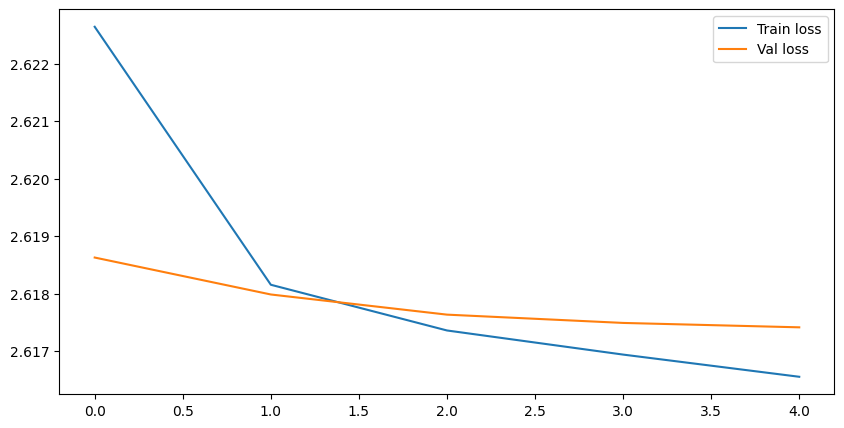

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend()

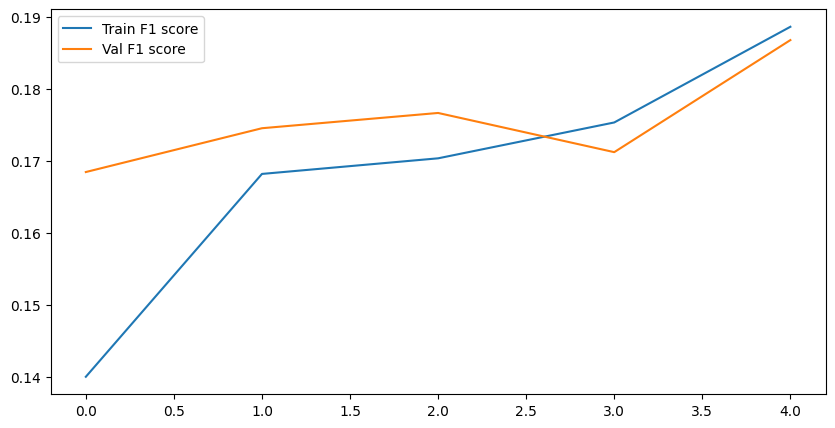

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label="Train F1 score")
plt.plot(val_f1_scores, label="Val F1 score")
plt.legend()

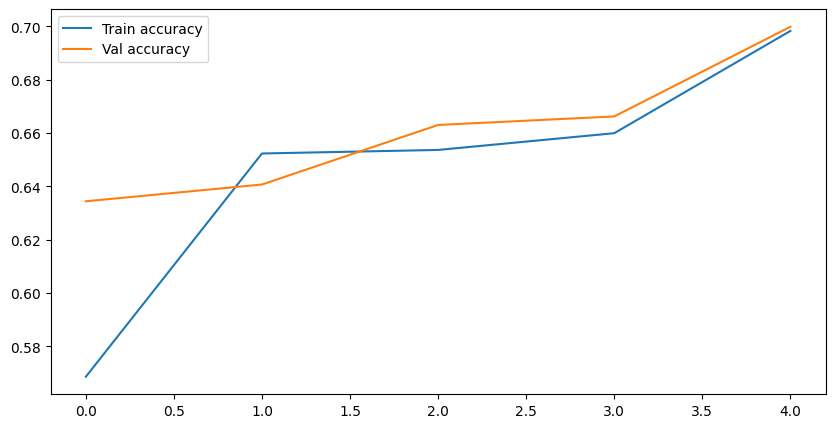

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_scores, label="Train accuracy")
plt.plot(val_accuracy_scores, label="Val accuracy")
plt.legend()

### LR Training and Testing

In [21]:
model = SequentialModel(label_dict_LR, torch.nn.GRU(300, 128, 1, batch_first=True))
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [22]:
model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores = \
train(model, LR_train_loader, LR_val_loader, criterion, optimizer, num_epochs=5)
torch.save(model, "../trained_models/t2_gru_word2vec.pt")

Epoch 1
Train loss: 1.0960413932800293, Val loss: 1.0916446447372437
Train accuracy: 0.7587592686930436, Val accuracy: 0.8093903888605876
Train F1: 0.372728531115652, Val F1: 0.448683333796825
Epoch 2
Train loss: 1.0894660472869873, Val loss: 1.0874696175257366
Train accuracy: 0.851177336276674, Val accuracy: 0.8794220863757287
Train F1: 0.4662585042378806, Val F1: 0.49056325386551136
Epoch 3
Train loss: 1.0868358691533406, Val loss: 1.0861868699391684
Train accuracy: 0.8867945887813438, Val accuracy: 0.9009735665364804
Train F1: 0.5108056362293726, Val F1: 0.5426089563214815
Epoch 4
Train loss: 1.0859485864639282, Val loss: 1.0855868339538575
Train accuracy: 0.9036055923473142, Val accuracy: 0.9065347823625969
Train F1: 0.5500396999807189, Val F1: 0.5558316664960102
Epoch 5
Train loss: 1.0853009144465129, Val loss: 1.0848303159077963
Train accuracy: 0.9143459557366842, Val accuracy: 0.9193835965359144
Train F1: 0.5677649737982693, Val F1: 0.5797440878280253


In [23]:
model.eval()
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for inputs, labels in LR_test_loader:
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
        outputs, hn = model(inputs)
        outputs = outputs.reshape(-1, outputs.shape[-1])
        labels = labels.reshape(-1)

        _, predicted = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
print(f"Test accuracy: {test_accuracy} Test F1: {test_f1}")

Test accuracy: 0.9193835965359144 Test F1: 0.5797440878280253


### Plots

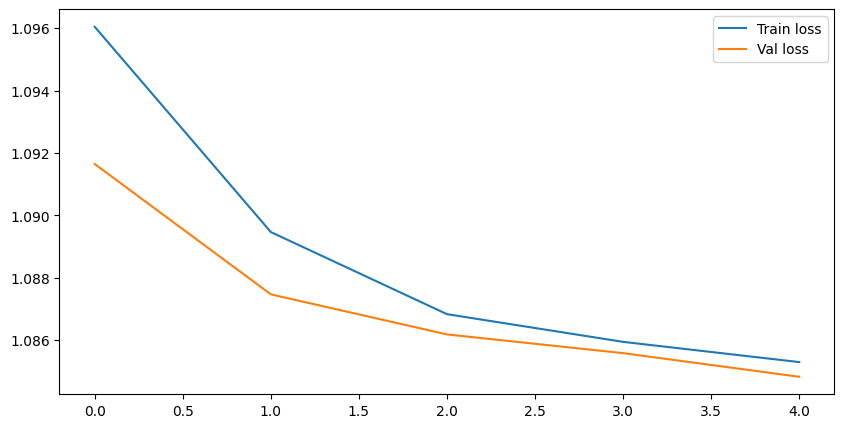

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend()

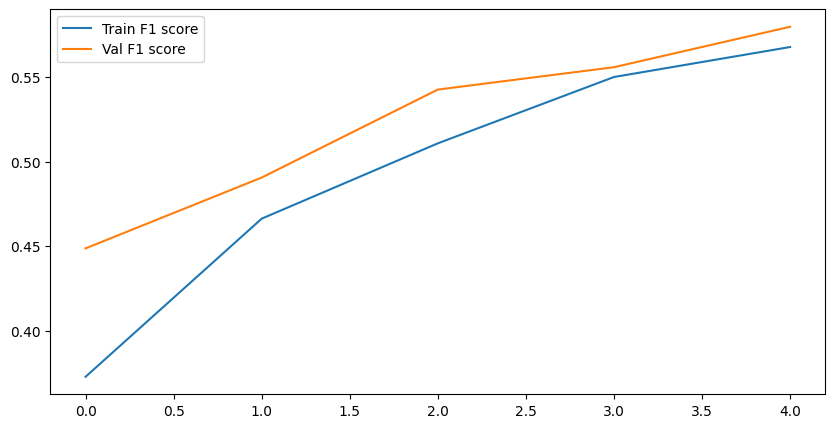

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label="Train F1 score")
plt.plot(val_f1_scores, label="Val F1 score")
plt.legend()

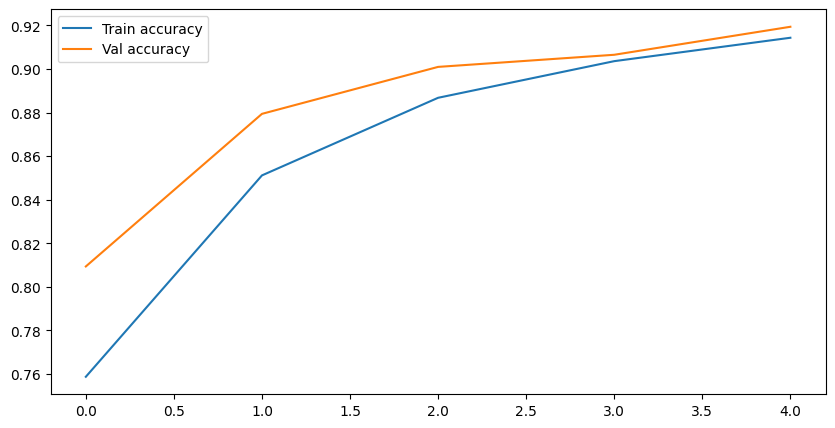

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_scores, label="Train accuracy")
plt.plot(val_accuracy_scores, label="Val accuracy")
plt.legend()

## GloVe Model

### Create batched and shuffled loaders for **Training, Validation and Testing** - NER

In [27]:
NER_train_loader = DataLoader(NER_dataset(NER_train, "glove", padding=True), batch_size=64, shuffle=True)
NER_val_loader = DataLoader(NER_dataset(NER_val, "glove", padding=True), batch_size=64, shuffle=True)
NER_test_loader = DataLoader(NER_dataset(NER_test, "glove", padding=True), batch_size=64, shuffle=True)

### Create batched and shuffled loaders for **Training, Validation and Testing** - LR

In [28]:
LR_train_loader = DataLoader(LR_dataset(LR_train, "glove", padding=True), batch_size=64, shuffle=True)
LR_val_loader = DataLoader(LR_dataset(LR_val, "glove", padding=True), batch_size=64, shuffle=True)
LR_test_loader = DataLoader(LR_dataset(LR_test, "glove", padding=True), batch_size=64, shuffle=True)

### Prepare modified model, criterion, optimizer

In [29]:
model = SequentialModel(label_dict_NER, torch.nn.GRU(300, 128, 1, batch_first=True))
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

### NER Training and Testing

In [30]:
model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores = \
train(model, NER_train_loader, NER_val_loader, criterion, optimizer, num_epochs=5)
torch.save(model, "../trained_models/t1_gru_glove.pt")

Epoch 1
Train loss: 2.6262448079807243, Val loss: 2.6236077617196476
Train accuracy: 0.647609482153464, Val accuracy: 0.7246697388632872
Train F1: 0.13059536264625543, Val F1: 0.15813270163183923
Epoch 2
Train loss: 2.622414215323851, Val loss: 2.6223765120786777
Train accuracy: 0.7029126842702089, Val accuracy: 0.6848663594470046
Train F1: 0.1618032771583526, Val F1: 0.17005640163305608
Epoch 3
Train loss: 2.6213937567681382, Val loss: 2.6219371767605053
Train accuracy: 0.712798747232572, Val accuracy: 0.7297695852534563
Train F1: 0.1783369078917119, Val F1: 0.1781706789167392
Epoch 4
Train loss: 2.6207852265269485, Val loss: 2.6217602561501896
Train accuracy: 0.7297759058264485, Val accuracy: 0.7292780337941628
Train F1: 0.18642706746732177, Val F1: 0.18214388890921995
Epoch 5
Train loss: 2.6202900802966247, Val loss: 2.6215986364028034
Train accuracy: 0.742340299152222, Val accuracy: 0.725173579109063
Train F1: 0.19343434777536078, Val F1: 0.18598020424011516


In [31]:
model.eval()
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for inputs, labels in NER_test_loader:
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
        outputs, hn = model(inputs)
        outputs = outputs.reshape(-1, outputs.shape[-1])
        labels = labels.reshape(-1)

        _, predicted = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
print(f"Test accuracy: {test_accuracy} Test F1: {test_f1}")

Test accuracy: 0.7169097222222223 Test F1: 0.1792576028367979


### Plots

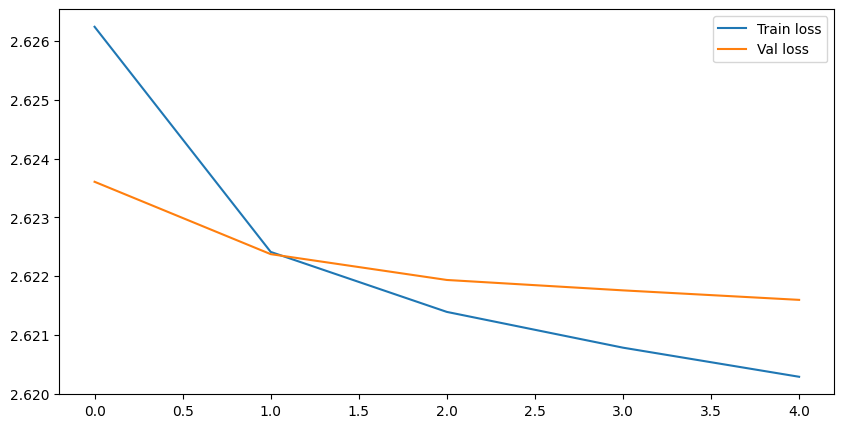

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend()

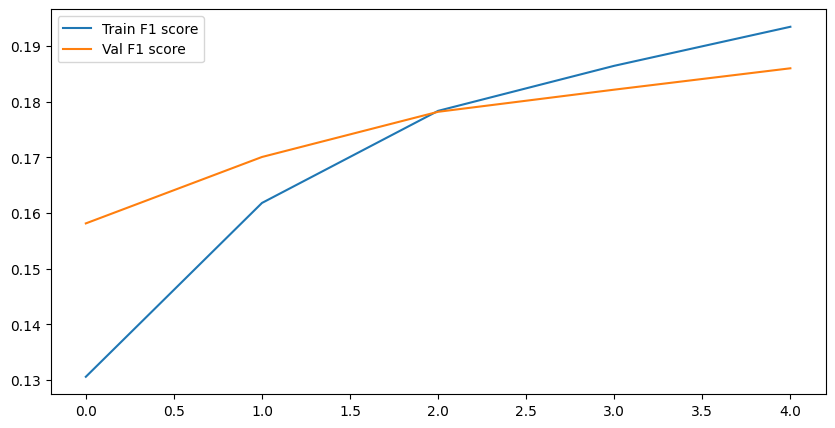

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label="Train F1 score")
plt.plot(val_f1_scores, label="Val F1 score")
plt.legend()

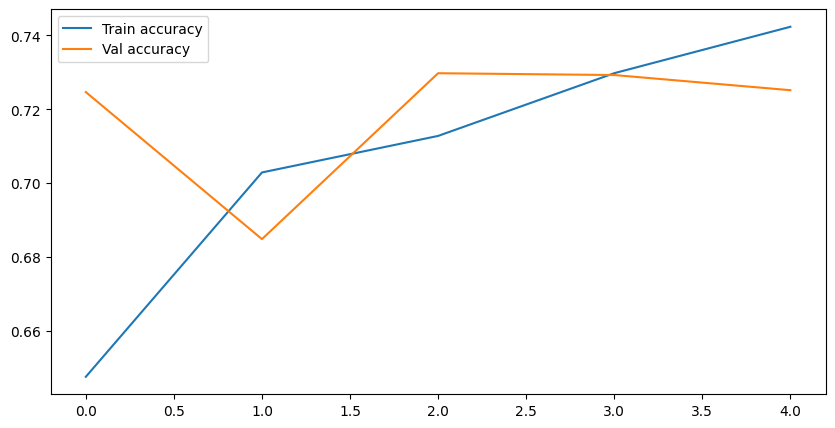

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_scores, label="Train accuracy")
plt.plot(val_accuracy_scores, label="Val accuracy")
plt.legend()

### LR Training

In [35]:
model = SequentialModel(label_dict_LR, torch.nn.GRU(300, 128, 1, batch_first=True))
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [36]:
model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores = \
train(model, LR_train_loader, LR_val_loader, criterion, optimizer, num_epochs=5)
torch.save(model, "../trained_models/t2_gru_glove.pt")

Epoch 1
Train loss: 1.0949661652247111, Val loss: 1.0904977083206178
Train accuracy: 0.7123733514461992, Val accuracy: 0.8606158374370295
Train F1: 0.3480936888017783, Val F1: 0.4708839186199718
Epoch 2
Train loss: 1.0894025484720866, Val loss: 1.0884633620580038
Train accuracy: 0.8505264051621667, Val accuracy: 0.8594837833248429
Train F1: 0.4646113506203065, Val F1: 0.4694641125936741
Epoch 3
Train loss: 1.0880565643310547, Val loss: 1.0868340810139974
Train accuracy: 0.8692052980132451, Val accuracy: 0.8714128035320088
Train F1: 0.477977074327998, Val F1: 0.49196829484442156
Epoch 4
Train loss: 1.0866949876149496, Val loss: 1.0860994021097818
Train accuracy: 0.8611394124639158, Val accuracy: 0.8887898341540725
Train F1: 0.487647197652342, Val F1: 0.5159736305348014
Epoch 5
Train loss: 1.0864149570465087, Val loss: 1.085693391164144
Train accuracy: 0.8874172185430463, Val accuracy: 0.8780353200883002
Train F1: 0.5201713850005166, Val F1: 0.5261572434045624


In [37]:
model.eval()
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for inputs, labels in LR_test_loader:
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
        outputs, hn = model(inputs)
        outputs = outputs.reshape(-1, outputs.shape[-1])
        labels = labels.reshape(-1)

        _, predicted = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
print(f"Test accuracy: {test_accuracy} Test F1: {test_f1}")

Test accuracy: 0.8780353200883002 Test F1: 0.5261572434045624


### Plots

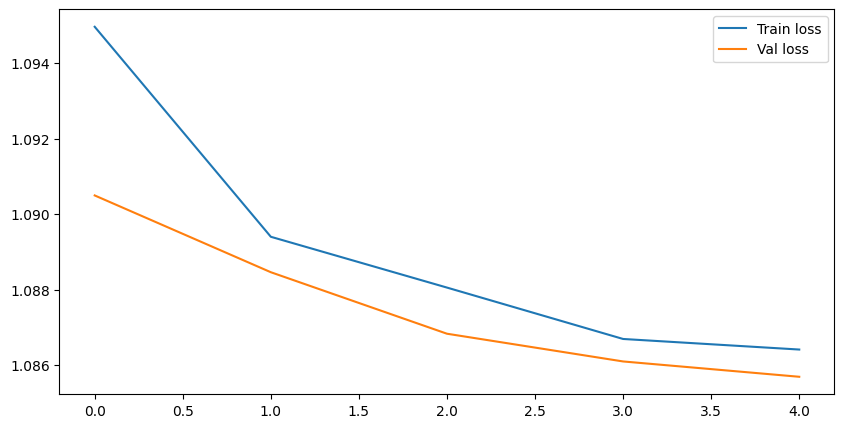

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend()

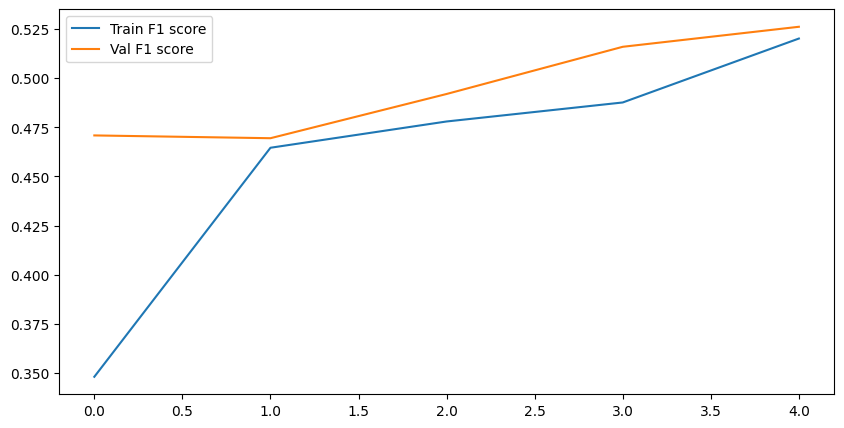

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label="Train F1 score")
plt.plot(val_f1_scores, label="Val F1 score")
plt.legend()

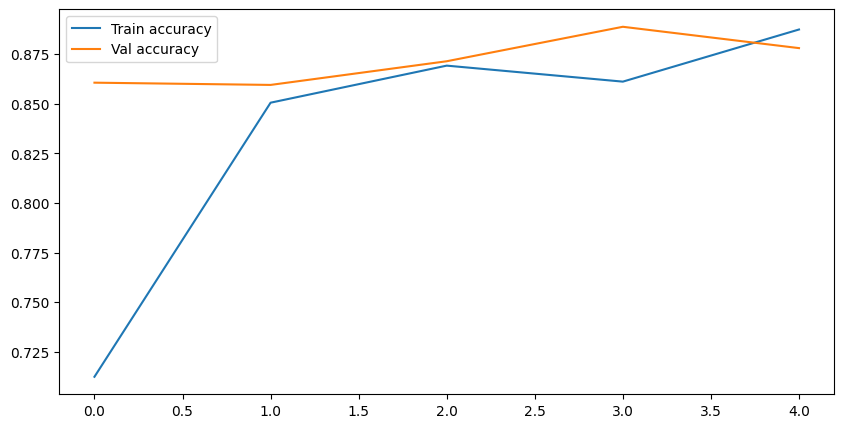

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_scores, label="Train accuracy")
plt.plot(val_accuracy_scores, label="Val accuracy")
plt.legend()

## Fasttext Model

### Create batched and shuffled loaders for **Training, Validation and Testing** - NER

In [41]:
NER_train_loader = DataLoader(NER_dataset(NER_train, "fasttext", padding=True), batch_size=64, shuffle=True)
NER_val_loader = DataLoader(NER_dataset(NER_val, "fasttext", padding=True), batch_size=64, shuffle=True)
NER_test_loader = DataLoader(NER_dataset(NER_test, "fasttext", padding=True), batch_size=64, shuffle=True)

### Create batched and shuffled loaders for **Training, Validation and Testing** - LR

In [42]:
LR_train_loader = DataLoader(LR_dataset(LR_train, "fasttext", padding=True), batch_size=64, shuffle=True)
LR_val_loader = DataLoader(LR_dataset(LR_val, "fasttext", padding=True), batch_size=64, shuffle=True)
LR_test_loader = DataLoader(LR_dataset(LR_test, "fasttext", padding=True), batch_size=64, shuffle=True)

### Prepare modified model, criterion, optimizer

In [43]:
model = SequentialModel(label_dict_NER, torch.nn.GRU(300, 128, 1, batch_first=True))
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

### NER Training and Testing

In [44]:
model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores = \
train(model, NER_train_loader, NER_val_loader, criterion, optimizer, num_epochs=5)
torch.save(model, "../trained_models/t1_gru_fasttext.pt")

Epoch 1
Train loss: 2.627532764808419, Val loss: 2.6239872399498436
Train accuracy: 0.6643598466439873, Val accuracy: 0.7268448540706606
Train F1: 0.132292393239725, Val F1: 0.15827168826346139
Epoch 2
Train loss: 2.623205411065485, Val loss: 2.6228707397685334
Train accuracy: 0.7125373940277553, Val accuracy: 0.6628325652841782
Train F1: 0.16198736806080258, Val F1: 0.15865246123571478
Epoch 3
Train loss: 2.622244898805913, Val loss: 2.6224618799546184
Train accuracy: 0.7328711053512609, Val accuracy: 0.7184393241167435
Train F1: 0.17578053882157516, Val F1: 0.17442869783475648
Epoch 4
Train loss: 2.6216417489592563, Val loss: 2.622403761919807
Train accuracy: 0.7462065986284356, Val accuracy: 0.7587956989247312
Train F1: 0.1849783516683418, Val F1: 0.18328556258274067
Epoch 5
Train loss: 2.621203007157316, Val loss: 2.622465456233305
Train accuracy: 0.7544791835412279, Val accuracy: 0.7570998463901689
Train F1: 0.1881264141366708, Val F1: 0.1844679735932319


In [45]:
model.eval()
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for inputs, labels in NER_test_loader:
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
        outputs, hn = model(inputs)
        outputs = outputs.reshape(-1, outputs.shape[-1])
        labels = labels.reshape(-1)

        _, predicted = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
print(f"Test accuracy: {test_accuracy} Test F1: {test_f1}")

Test accuracy: 0.7512673611111111 Test F1: 0.1819635656848996


### Plots

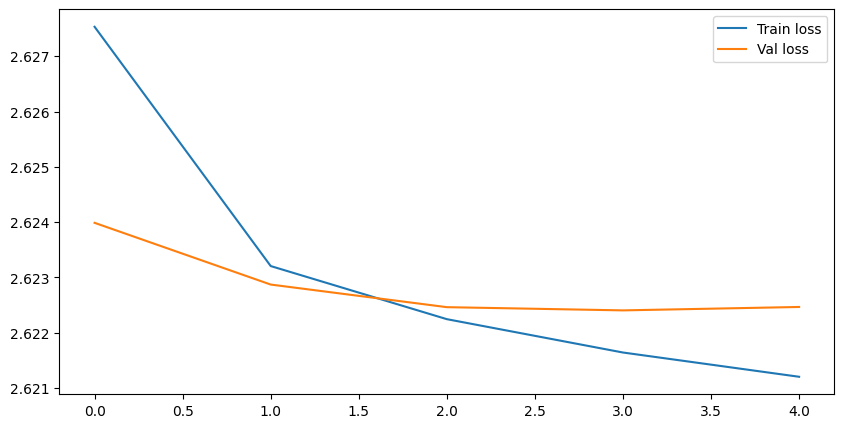

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend()

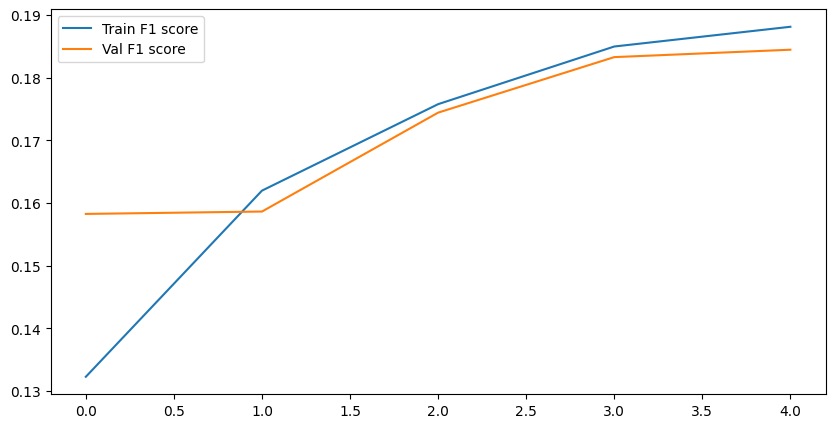

In [47]:
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label="Train F1 score")
plt.plot(val_f1_scores, label="Val F1 score")
plt.legend()

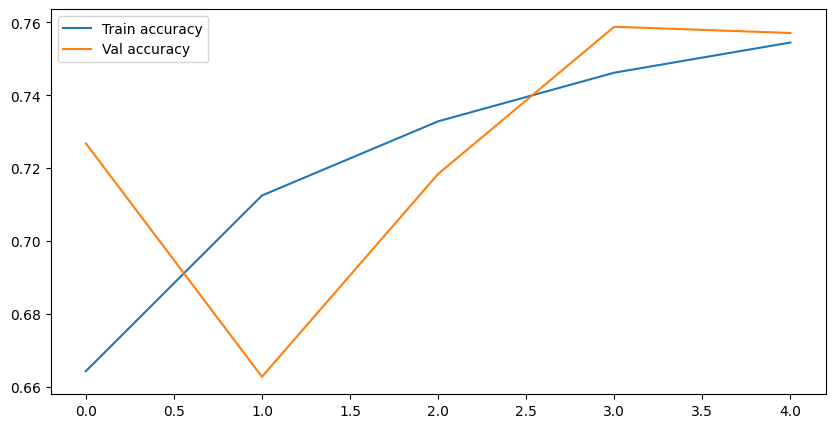

In [48]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_scores, label="Train accuracy")
plt.plot(val_accuracy_scores, label="Val accuracy")
plt.legend()

### LR Training and Testing

In [49]:
model = SequentialModel(label_dict_LR, torch.nn.GRU(300, 128, 1, batch_first=True))
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [50]:
model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores = \
train(model, LR_train_loader, LR_val_loader, criterion, optimizer, num_epochs=5)
torch.save(model, "../trained_models/t2_gru_fasttext.pt")

Epoch 1
Train loss: 1.0958918571472167, Val loss: 1.09184943040212
Train accuracy: 0.6859540386030453, Val accuracy: 0.7966123280692817
Train F1: 0.338043870529997, Val F1: 0.44657049589253117
Epoch 2
Train loss: 1.0900663693745931, Val loss: 1.0881855964660645
Train accuracy: 0.8390643572762778, Val accuracy: 0.8653846153846154
Train F1: 0.4550887707029701, Val F1: 0.4649538694271566
Epoch 3
Train loss: 1.0880131800969441, Val loss: 1.0874499559402466
Train accuracy: 0.8725590083205977, Val accuracy: 0.8641110545084055
Train F1: 0.47257037204480695, Val F1: 0.47285256001325315
Epoch 4
Train loss: 1.087151535352071, Val loss: 1.08652765750885
Train accuracy: 0.8680024905190468, Val accuracy: 0.8740448293428426
Train F1: 0.4808374623075675, Val F1: 0.5021536669136762
Epoch 5
Train loss: 1.0866562763849894, Val loss: 1.0861542304356893
Train accuracy: 0.8615497820795834, Val accuracy: 0.840946397237788
Train F1: 0.49303321185743637, Val F1: 0.4934949382596296


In [51]:
model.eval()
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for inputs, labels in LR_test_loader:
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
        outputs, hn = model(inputs)
        outputs = outputs.reshape(-1, outputs.shape[-1])
        labels = labels.reshape(-1)

        _, predicted = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
print(f"Test accuracy: {test_accuracy} Test F1: {test_f1}")

Test accuracy: 0.840946397237788 Test F1: 0.4934949382596296


### Plots

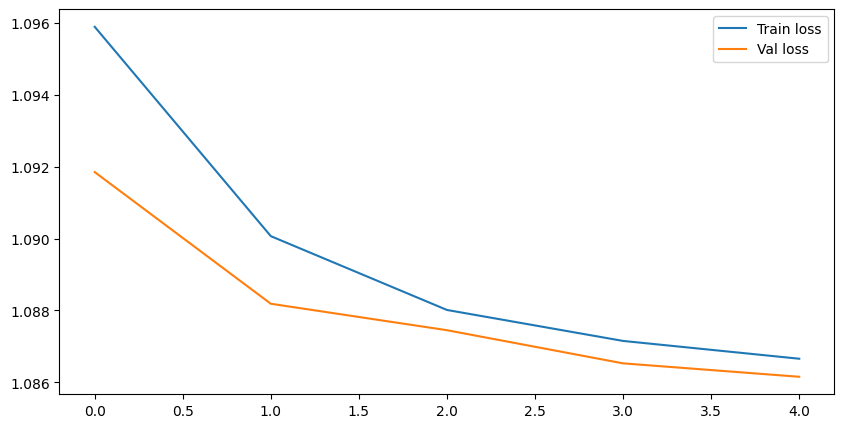

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend()

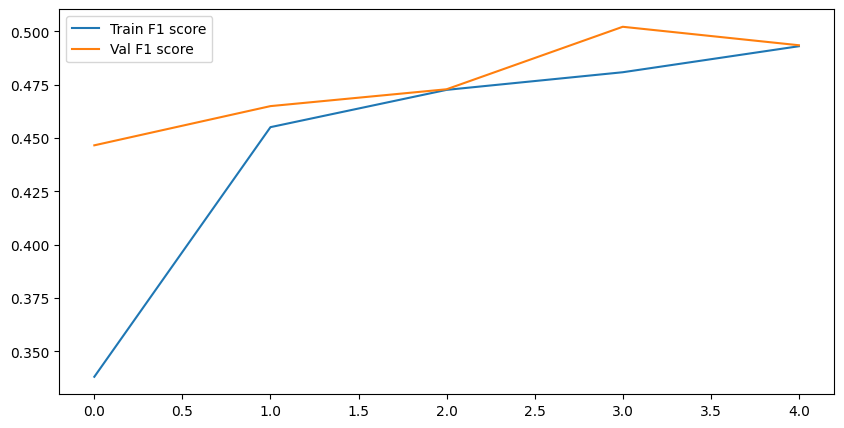

In [53]:
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label="Train F1 score")
plt.plot(val_f1_scores, label="Val F1 score")
plt.legend()

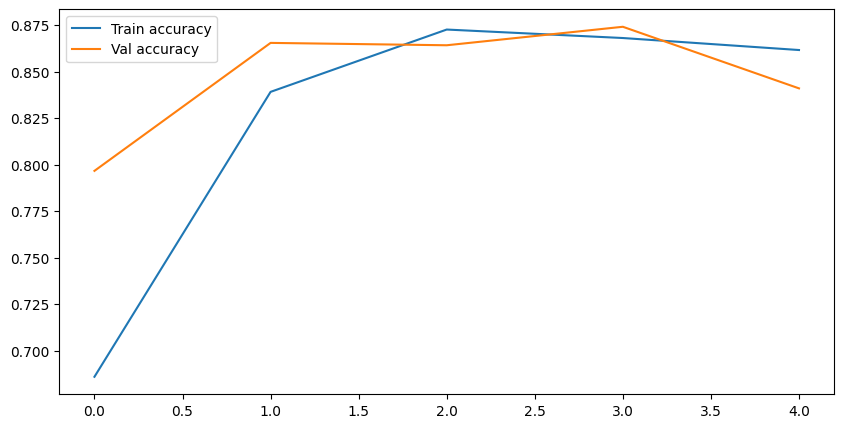

In [54]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_scores, label="Train accuracy")
plt.plot(val_accuracy_scores, label="Val accuracy")
plt.legend()